[Reference: My Life as a Mock Quant / R言語でスライスサンプリング(Slice Sampling)を実装してみた](http://d.hatena.ne.jp/teramonagi/20130203/1359888495)

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 7, 5

In [3]:
import numpy as np
import scipy as sp
import numpy.random as npr
import seaborn as sns
import matplotlib.pyplot as plt

# Likelihood

これが$g(x) = \log f(x)$に相当するもの

In [4]:
def g_linear(param): # linear
    a = param[0][0]
    b = 7
    sd = 10
    
    pred = a*x + b # 要するにこれが「モデル」
    
    sumSqError = np.power((y - pred), 2).sum()
    
    likelihoodsum = ((sample_size/2)*(np.log(1)-np.log(np.power(sd,2)))) + (- 1/(2*np.power(sd,2)) * sumSqError)
    
    return likelihoodsum

In [5]:
def g_gaussian(param): # Gaussian --> Wikipedia / mixture Gaussian --> PRML (9.14)
    mu = param[0][0]
    
    loglikelihoodsum = np.sum( (1 / np.sqrt(2 * np.pi * np.power(sd,2))) * np.exp( -( np.power(points - mu, 2) / (2*np.power(sd,2)) )) )
    
    return loglikelihoodsum

# Slice Sampling Functions

In [6]:
def is_in_S(chain, z, g):
    if z < g(chain):
        return True
    else:
        return False

In [7]:
def stepping_out(x, w, g, z):
    r = npr.uniform(0, 1)
    xl = x - r*w
    xr = x + (1-r)*w
    
    # Find Intrval around x
    while(is_in_S(xl, z, g)):
        xl -= w
        
    while(is_in_S(xr, z, g)):
        xr += w
        
    return xl, xr

In [8]:
def sampling(initial_value, num_sampling, g):
    chain = np.zeros((num_sampling, 1, 1))
    chain[0][0][0] = initial_value # starting value
    w = 1

    for i in range(0, num_sampling-1):
        z = g(chain[i]) - npr.exponential(1)

        # interval
        xl, xr = stepping_out(chain[i], w, g, z)

        while True:
            # sample next point (ITILA p.375, inside the loop, l5~)
            x_new = xl + npr.uniform(0,1) * (xr - xl)

            if is_in_S(x_new, z, g):
                break

            if x_new > chain[i]:
                xr = x_new
            else:
                xl = x_new

        chain[i+1][0][0] = float(x_new)
        
    return chain

# Linear Model

## Create Data Set

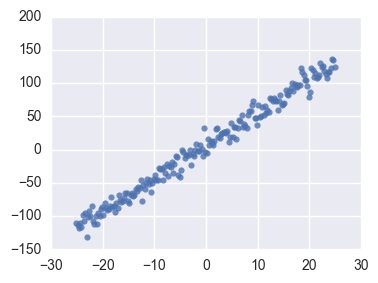

In [9]:
trueA = 5
trueB = 7
trueSD = 10
sample_size = 201
x = np.arange(-sample_size/8, sample_size/8, (sample_size*2/8)/sample_size)
y = trueA *x + trueB + npr.normal(loc=0, scale=trueSD, size=sample_size)

pylab.rcParams['figure.figsize'] = 4, 3
sns.regplot(x=x, y=y, fit_reg=False)
pylab.rcParams['figure.figsize'] = 7, 3

## Slice Sampling

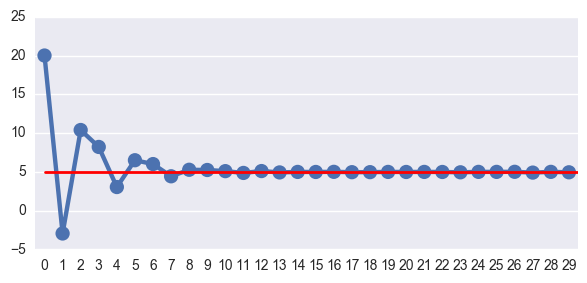

In [10]:
num_sampling = 30
initial_value = 20
sns.pointplot(x=np.arange(0, num_sampling, 1), y=sampling(initial_value, num_sampling, g_linear)[:, 0, 0])
plt.plot([0, num_sampling], [trueA, trueA], linewidth=2, color='red')

# Gaussian

## Create Data

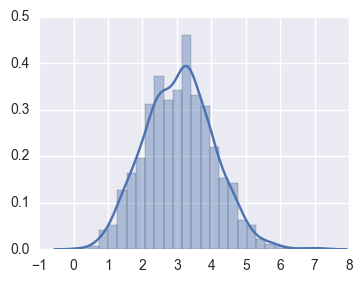

In [11]:
mu = 3 ; sd = 1
sample_size = 1000
x = np.arange(-6, 6, (6+6)/sample_size)

# Gaussian Mixture
#points = np.append(npr.normal(-mu, sd, int(sample_size*0.2)), npr.normal(mu, sd, int(sample_size*0.8)))

# Gaussian
points = npr.normal(mu, sd, int(sample_size))

pylab.rcParams['figure.figsize'] = 4, 3
sns.distplot(points)
pylab.rcParams['figure.figsize'] = 7, 3

## Slice Sampling

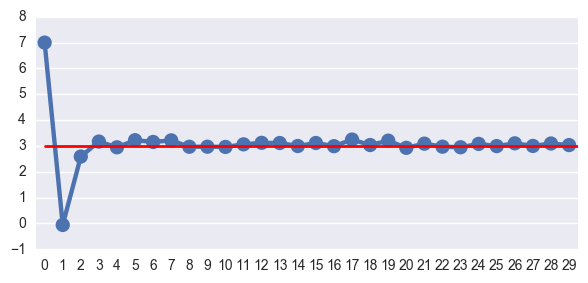

In [12]:
num_sampling = 30
initial_value = 7.0
sns.pointplot(x=np.arange(0, num_sampling, 1), y=sampling(initial_value, num_sampling, g_gaussian)[:, 0, 0])
plt.plot([0, num_sampling], [mu, mu], linewidth=2, color='red')

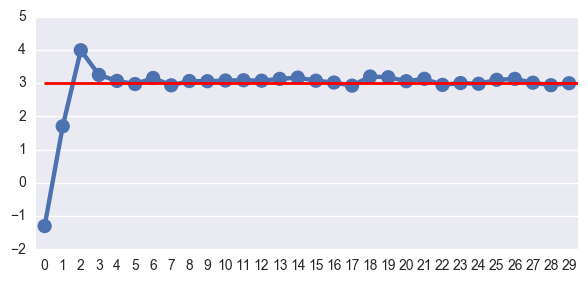

In [13]:
num_sampling = 30
initial_value = -1.3
sns.pointplot(x=np.arange(0, num_sampling, 1), y=sampling(initial_value, num_sampling, g_gaussian)[:, 0, 0])
plt.plot([0, num_sampling], [mu, mu], linewidth=2, color='red')